![QuantConnect Logo](https://cdn.quantconnect.com/web/i/icon.png)
<hr>

In [1]:
import kmapper as km
import networkx as nx
from persim import plot_diagrams, wasserstein
from ripser import Rips, ripser
from scipy.signal import find_peaks
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import umap

import warnings
warnings.filterwarnings("ignore")

2025-10-16 11:08:45.575988: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 11:08:45.626545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760612925.656200      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760612925.664619      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760612925.715454      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# QuantBook Analysis Tool
# For more information see [https://www.quantconnect.com/docs/v2/our-platform/research/getting-started]
qb = QuantBook()
start_date = datetime(2020, 1, 1)
qb.set_start_date(start_date)

universe = qb.add_universe(qb.universe.etf("QQQ", Market.USA))
universe_history = qb.universe_history(universe, start_date-timedelta(1), start_date)
symbols = [x.symbol for x in universe_history.iloc[-1]]

prices = qb.history(symbols, 200, Resolution.DAILY).unstack(0).close
# Calculate daily log return. Then, transpose the data since we're linking stocks.
log_returns = np.log(prices / prices.shift(1)).dropna().T

In [3]:
def construct_simplicial_complex(log_returns):
    # Initialize the mapper algorithm.
    mapper = km.KeplerMapper()
    # Project the data into a 2d subspace via 2 transformation, PCA and UMAP.
    # PCA: since it can retain the most variance while denoising, as well as fast.
    # UMAP: handles non-linear relationships well and preserves both local and global structures.
    # MDS and Isomap are not included due to their potential sensitivity to noise and outliers in financial data.
    projected_data = mapper.fit_transform(log_returns, projection=[PCA(n_components=0.85, random_state=321), umap.UMAP(n_components=1, random_state=124)])
    # Cluster the data with DBSCAN since it is better in handling noise.
    graph = mapper.map(projected_data, log_returns, clusterer=DBSCAN(metric='correlation', n_jobs=-1))

    return projected_data, graph

# Construct simplicial complex
projected_data, graph = construct_simplicial_complex(log_returns)
graph

{'nodes': defaultdict(list,
             {'cube0_cluster0': [8, 51, 56, 72, 73, 91, 102],
              'cube1_cluster0': [3, 14, 20, 59, 62, 68, 73, 87, 91],
              'cube2_cluster0': [2, 11, 32, 59, 78, 85, 90, 95],
              'cube3_cluster0': [5, 9, 12, 28, 41, 52, 66, 86, 98],
              'cube4_cluster0': [4, 12, 13, 31, 53]}),
 'links': defaultdict(list,
             {'cube0_cluster0': ['cube1_cluster0'],
              'cube1_cluster0': ['cube2_cluster0'],
              'cube3_cluster0': ['cube4_cluster0']}),
 'simplices': [['cube0_cluster0'],
  ['cube1_cluster0'],
  ['cube2_cluster0'],
  ['cube3_cluster0'],
  ['cube4_cluster0'],
  ['cube0_cluster0', 'cube1_cluster0'],
  ['cube1_cluster0', 'cube2_cluster0'],
  ['cube3_cluster0', 'cube4_cluster0']],
 'meta_data': {'projection': 'UMAP(n_components=1, random_state=124)',
  'n_cubes': 10,
  'perc_overlap': 0.1,
  'clusterer': "DBSCAN(metric='correlation', n_jobs=-1)",
  'scaler': 'MinMaxScaler()',
  'nerve_min_intersectio

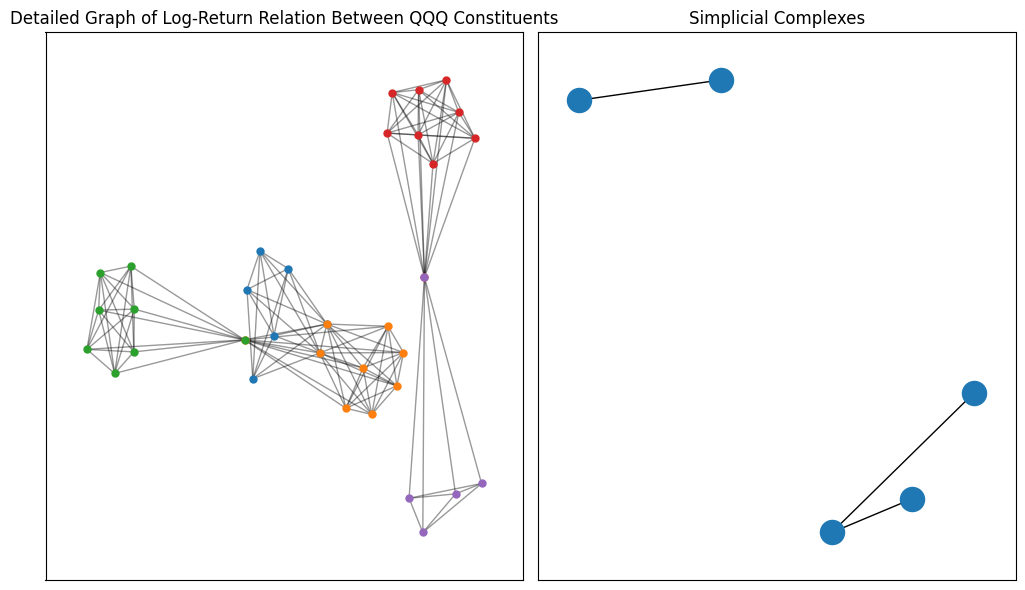

In [4]:
fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(121)
# Create a graph using NetworkX
G = nx.from_dict_of_lists({x: [z for z in y if z != x] for y in graph['nodes'].values() for x in y})
# Group the nodes and position them in a graph.
pos = nx.spring_layout(G, k=0.2, iterations=15, seed=74)
# Nodes colored by cluster
for nodes, color in zip(list(graph['nodes'].values()), ("tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:pink", "tab:brown", "tab:cyan", "tab:grey", "yellow")):
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, node_size=25, ax=ax)
nx.draw_networkx_edges(G, pos, alpha=0.4, ax=ax)
plt.title("Detailed Graph of Log-Return Relation Between QQQ Constituents")

# Plot the simplicial complexes.
ax2 = fig.add_subplot(122)
# Extract nodes and links
nodes = graph["nodes"].keys()
edges = [[start, end] for start, ends in graph["links"].items() for end in ends]
# Create the graph.
g = nx.Graph()
g.add_nodes_from(nodes)
nx.set_node_attributes(g, dict(graph["nodes"]), "membership")
g.add_edges_from(edges)
# Draw the graph.
pos = nx.spring_layout(g, k=1, iterations=30, seed=435)
nodes = nx.draw_networkx_nodes(g, node_size=300, pos=pos, ax=ax2)
nx.draw_networkx_edges(g, pos=pos, ax=ax2, arrows=False)
ax2.set_title("Simplicial Complexes")

plt.tight_layout()
plt.show()